In [21]:
#! pip install torch transformers sentencepiece

In [22]:
#! pip install regex protobuf

In [23]:
#! pip install Bio

In [24]:
#! pip install scikit-learn matplotlib

## Install dependecies
<p>! pip install torch transformers sentencepiece<p>
<p>! pip install regex protobuf<p>
<p>! pip install Bio<p>
<p>! pip install scikit-learn matplotlib<p>

In [2]:
# import required packages
import torch
import pandas as pd
import re
import os
import numpy as np
import matplotlib.pyplot as plt
from transformers import T5Tokenizer, T5EncoderModel
from Bio import SeqIO
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc

In [3]:
# Clear CUDA cache before loading the model
torch.cuda.empty_cache()

In [4]:
# Define device
device = torch.device('cuda')

In [5]:
# Load ProtT5 model and tokenizer
transformer_link = "Rostlab/prot_t5_xl_uniref50"
print("Loading: {}".format(transformer_link))
model = T5EncoderModel.from_pretrained(transformer_link).to(device)
model.eval()  # Set model to evaluation mode

Loading: Rostlab/prot_t5_xl_uniref50


config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

T5EncoderModel(
  (shared): Embedding(128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=4096, bias=False)
              (k): Linear(in_features=1024, out_features=4096, bias=False)
              (v): Linear(in_features=1024, out_features=4096, bias=False)
              (o): Linear(in_features=4096, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=16384, bias=False)
              (wo): Linear(in_features=16384, out_features=1024, bias=False)
              (dropout): Dropo

In [6]:
# tokenizer
tokenizer = T5Tokenizer.from_pretrained(transformer_link, do_lower_case=False, legacy=True)

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

In [7]:
# Function to process sequences and generate embeddings
def generate_embeddings(fasta_file, label):
    sequences = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        # Replace rare/ambiguous amino acids by X
        sequence = re.sub(r"[UZOB]", "X", str(record.seq))
        sequences.append(sequence)

    embeddings = []
    for sequence in sequences:
        # Tokenize and pad sequences
        sequence_with_spaces = " ".join(list(sequence))
        ids = tokenizer.encode_plus(sequence_with_spaces, add_special_tokens=True, padding="longest", return_tensors="pt")

        input_ids = ids['input_ids'].to(device)
        attention_mask = ids['attention_mask'].to(device)

        # Generate embeddings
        with torch.no_grad():
            embedding_repr = model(input_ids=input_ids, attention_mask=attention_mask)

        # Extract per-protein embedding
        per_protein_embedding = embedding_repr.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
        embeddings.append(per_protein_embedding)

    # Create a DataFrame with embeddings and labels
    df_embeddings = pd.DataFrame(embeddings)
    df_embeddings['label'] = label  # Assign label based on input

    return df_embeddings

In [8]:
# File paths for samples

file_paths = {
    'neg_train' : 'Dataset/S_tr_nega.fa',
    'pos_train' : 'Dataset/S_tr_posi.fa',
    'neg_test' : 'Dataset/S_tst_nega.fa',
    'pos_test' : 'Dataset/S_tst_posi.fa'
}

In [9]:
# Generate embeddings and save each DataFrame separately
for file_type, path in file_paths.items():
    if "neg" in file_type:
        label = 1  # Label for negative samples
    else:
        label = 0  # Label for positive samples

    embeddings_df = generate_embeddings(path, label)

    # Save each embeddings DataFrame to a separate CSV file
    output_file = f"{file_type}_embeddings.csv"
    embeddings_df.to_csv(output_file, index=False)
    print(f"Embeddings saved to {output_file}")

Embeddings saved to neg_train_embeddings.csv
Embeddings saved to pos_train_embeddings.csv
Embeddings saved to neg_test_embeddings.csv
Embeddings saved to pos_test_embeddings.csv


sequences = []
for record in SeqIO.parse(fasta_file, "fasta"):
        # Replace rare/ambiguous amino acids by X
    sequence = re.sub(r"[UZOB]", "X", str(record.seq))
    sequences.append(sequence)

#### At this stage embedding has been generated and saved

### Classification using multilayer perceptron (MLP) classifier

In [10]:
# Loading training and testing embeddings
##train
df1=pd.read_csv("neg_train_embeddings.csv")
df2=pd.read_csv("pos_train_embeddings.csv")

###test
df3=pd.read_csv("neg_test_embeddings.csv")
df4=pd.read_csv("pos_test_embeddings.csv")

#df1.shape,df2.shape,df3.shape,df4.shape

In [11]:
# Concateating ans shuffling the training dataset
combined_df_train = pd.concat([df1, df2], ignore_index=True)

df_train = combined_df_train.sample(frac=1).reset_index(drop=True)

In [12]:
# Concateating ans shuffling the test dataset
combined_df_test = pd.concat([df3, df4], ignore_index=True)
df_test = combined_df_test.sample(frac=1).reset_index(drop=True)

In [13]:
# Separating features and labels for train and test
X_train= df_train.iloc[:,:-1]
y_train= df_train.iloc[:,-1]
X_test= df_test.iloc[:,:-1]
y_test= df_test.iloc[:,-1]

In [14]:
# Initialize and train the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

MLPClassifier(max_iter=500, random_state=42)

In [15]:
#Make predictions
y_pred = mlp.predict(X_test)
y_pred_proba = mlp.predict_proba(X_test)[:, 1]  # Probabilities for the positive class


In [16]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.79


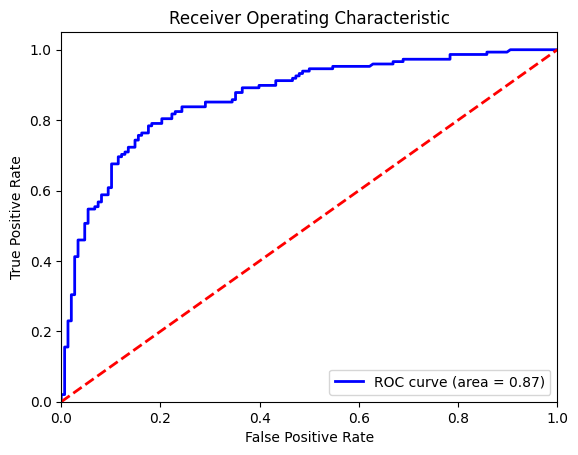

In [17]:
# Calculate and plot ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
